In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from keras import Sequential
from keras.models import load_model
# from models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:496: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [3]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

### Data Visualization and Preprocessing

In [26]:
rawdf = pd.read_csv('calculary_salary.csv')
#rawdf.head()
salary_df = rawdf[['Bang_cap', 'Mang_cong_viec', 'Nam_kinh_nghiem', 'Vi_tri', 'Nang_luc_work', 'Luong']]
salary_df.head(50)

,Bang_cap,Mang_cong_viec,Nam_kinh_nghiem,Vi_tri,Nang_luc_work,Luong
0,Dai hoc,BA,0,Nhan vien,C,7.0
1,Cao dang,Lap trinh vien,2,Nhan vien,B,11.1
2,Dai hoc,Lap trinh vien,4,Nhan vien,B,12.5
3,Khong bang cap,Lap trinh vien,5,Nhan vien,D,8.5
4,Cao dang,Tester,6,Teamlead,B,16.0
5,Dai hoc,Tu van ban hang,15,Nhan vien,A,19.0
6,Thac si,Lap trinh vien,2,Teamlead,A,18.0
7,Cao dang,Lap trinh vien,4,Nhan vien,D,8.5
8,Khong bang cap,Lap trinh vien,0,Nhan vien,D,5.0
9,Khong bang cap,Lap trinh vien,20,Nhan vien,C,14.0


In [5]:
#rawdf.info()
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
Bang_cap           10000 non-null object
Mang_cong_viec     10000 non-null object
Nam_kinh_nghiem    10000 non-null int64
Vi_tri             10000 non-null object
Nang_luc_work      10000 non-null object
Luong              10000 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 468.8+ KB


In [6]:
#rawdf.describe()
salary_df.describe()

,Nam_kinh_nghiem,Luong
count,10000.000000,10000.000000
mean,4.079000,11.714086
std,5.173668,5.947426
min,0.000000,2.200000
25%,0.000000,7.460000
50%,2.000000,11.100000
75%,6.000000,14.100000
max,39.000000,65.000000


In [7]:
(rawdf['Luong'].value_counts()) / rawdf['Luong'].count()

12.00    0.1487
9.00     0.0977
5.00     0.0940
7.00     0.0886
14.00    0.0567
19.00    0.0564
16.00    0.0557
7.10     0.0453
14.10    0.0427
9.10     0.0426
11.10    0.0405
10.50    0.0325
8.50     0.0293
15.50    0.0291
12.50    0.0285
15.00    0.0203
25.00    0.0093
30.20    0.0089
47.00    0.0087
18.00    0.0081
20.00    0.0063
9.20     0.0048
6.20     0.0045
2.20     0.0041
6.40     0.0033
13.40    0.0032
5.46     0.0029
10.40    0.0029
4.20     0.0028
35.00    0.0026
10.46    0.0025
8.40     0.0023
3.46     0.0018
4.30     0.0016
8.30     0.0016
7.46     0.0015
22.00    0.0012
11.30    0.0011
6.30     0.0009
17.00    0.0009
20.12    0.0007
24.50    0.0005
44.00    0.0005
27.50    0.0005
65.00    0.0005
27.20    0.0004
32.00    0.0002
21.50    0.0001
41.00    0.0001
38.00    0.0001
Name: Luong, dtype: float64

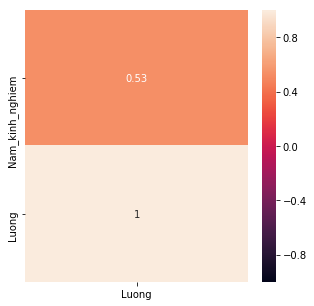

In [8]:
plt.figure(figsize=(5, 5))
#sns.heatmap(rawdf.corr()[['Luong']], annot=True, vmin=-1, vmax=1)
sns.heatmap(salary_df.corr()[['Luong']], annot=True, vmin=-1, vmax=1)

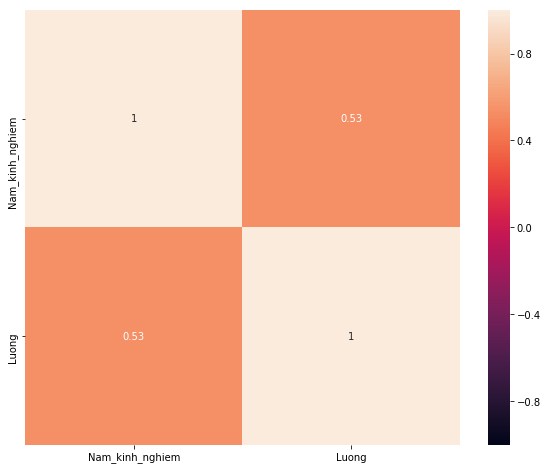

In [9]:
plt.figure(figsize=(10, 8))
#sns.heatmap(rawdf.corr(), annot=True, square=True, vmin=-1, vmax=1)
sns.heatmap(salary_df.corr(), annot=True, square=True, vmin=-1, vmax=1)

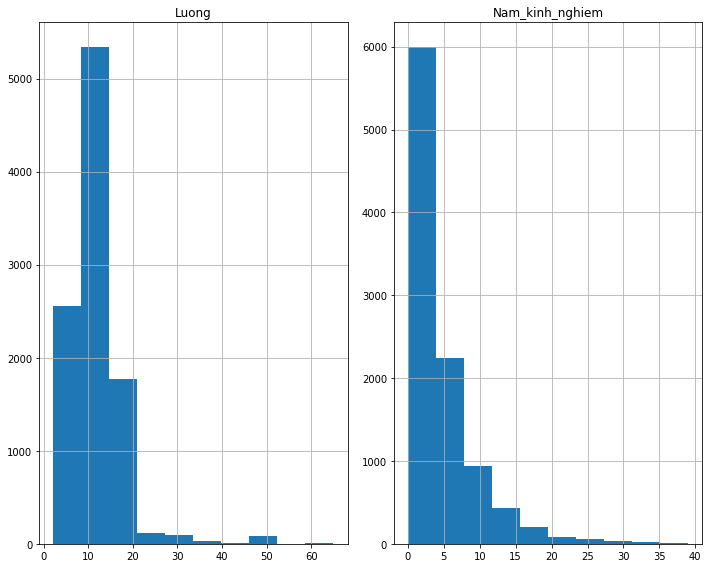

In [10]:
#rawdf.hist(figsize=(10, 8))
salary_df.hist(figsize=(10, 8))
plt.tight_layout()

In [11]:
# Preprocessing data
#df = rawdf.copy()
df = salary_df.copy()

# Batch normalization
ss = StandardScaler()
scale_features = ['Nam_kinh_nghiem']
df[scale_features] = ss.fit_transform(df[scale_features])

# Convert categorical data to one-hot representation
categorical_features = ['Bang_cap', 'Mang_cong_viec', 'Nam_kinh_nghiem', 'Vi_tri', 'Nang_luc_work']
df_cat = pd.get_dummies(df[categorical_features]) # get_dummies giống với one-hot-encoder
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,Luong,Nam_kinh_nghiem,Bang_cap_Cao dang,Bang_cap_Dai hoc,Bang_cap_Khong bang cap,Bang_cap_Thac si,Bang_cap_Tien si,Mang_cong_viec_BA,Mang_cong_viec_Ke toan,Mang_cong_viec_Ky su R&D,...,Mang_cong_viec_Tu van ban hang,Mang_cong_viec_Xu ly data,Vi_tri_Nhan vien,Vi_tri_Teamlead,Vi_tri_Technical leader,Vi_tri_Truong phong,Nang_luc_work_A,Nang_luc_work_B,Nang_luc_work_C,Nang_luc_work_D
0,7.0,-0.788455,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,11.1,-0.401863,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,12.5,-0.015270,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,8.5,0.178026,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,16.0,0.371322,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [12]:
# Convert data from dataframe to numpy array
x_data = df.drop('Luong', axis=1).values
y_data = df['Luong'].values
print(x_data[0])
print(y_data[0])
# Split data train and test
x_train= []
x_test=[]
y_train=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state=0)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

[-0.78845499  0.          1.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          1.          0.        ]
7.0
x_train.shape =  (9000, 22)
y_train.shape =  (9000,)
x_test.shape =  (1000, 22)
y_test.shape =  (1000,)


## Linear Regression Model

Train on 7200 samples, validate on 1800 samples
Epoch 1/30
7200/7200 [==============================] - 1s 157us/step - loss: 149.8345 - val_loss: 146.3897
Epoch 2/30
7200/7200 [==============================] - 0s 31us/step - loss: 128.0175 - val_loss: 125.4770
Epoch 3/30
7200/7200 [==============================] - 0s 35us/step - loss: 109.2138 - val_loss: 107.4641
Epoch 4/30
7200/7200 [==============================] - 0s 30us/step - loss: 93.1423 - val_loss: 92.0774
Epoch 5/30
7200/7200 [==============================] - 0s 34us/step - loss: 79.4967 - val_loss: 78.9985
Epoch 6/30
7200/7200 [==============================] - 0s 41us/step - loss: 67.9955 - val_loss: 68.0259
Epoch 7/30
7200/7200 [==============================] - 0s 31us/step - loss: 58.3962 - val_loss: 58.8431
Epoch 8/30
7200/7200 [==============================] - 0s 34us/step - loss: 50.4472 - val_loss: 51.2609
Epoch 9/30
7200/7200 [==============================] - 0s 30us/step - loss: 43.9338 - val_loss: 45.0052


<Figure size 576x432 with 0 Axes>

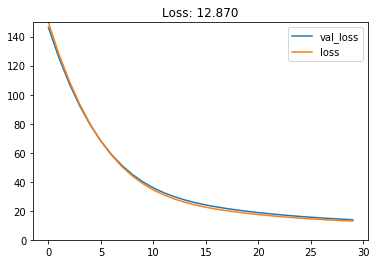

In [13]:
linr_model = Sequential()
linr_model.add(Dense(1, input_shape=(x_train.shape[1],)))

linr_model.compile('adam', 'mean_squared_error')

linr_history = linr_model.fit(x_train, y_train, verbose=1, epochs=30, validation_split=0.2)
plot_loss(linr_history)

In [14]:
# Evaluate
accuracy = np.mean(abs(1-2) <=1)
print("accuracy =", accuracy )

accuracy = 1.0


## Logistic Regression Model

In [15]:
lr_model = Sequential()
lr_model.add(Dense(1, input_shape=(x_train.shape[1],), activation='sigmoid'))

#lr_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])
lr_model.compile(Adam(lr=0.01), 'mean_squared_error')
lr_history = lr_model.fit(x_train, y_train, verbose=1, epochs=30)
#plot_loss_accuracy(lr_history)

Epoch 1/30
9000/9000 [==============================] - 0s 39us/step - loss: 152.6134
Epoch 2/30
9000/9000 [==============================] - 0s 32us/step - loss: 151.1680
Epoch 3/30
9000/9000 [==============================] - 0s 31us/step - loss: 151.1077
Epoch 4/30
9000/9000 [==============================] - 0s 31us/step - loss: 151.0880
Epoch 5/30
9000/9000 [==============================] - 0s 28us/step - loss: 151.0788
Epoch 6/30
9000/9000 [==============================] - 0s 27us/step - loss: 151.0737
Epoch 7/30
9000/9000 [==============================] - 0s 31us/step - loss: 151.0705
Epoch 8/30
9000/9000 [==============================] - 0s 32us/step - loss: 151.0684
Epoch 9/30
9000/9000 [==============================] - 0s 28us/step - loss: 151.0669
Epoch 10/30
9000/9000 [==============================] - 0s 30us/step - loss: 151.0658
Epoch 11/30
9000/9000 [==============================] - 0s 27us/step - loss: 151.0650
Epoch 12/30
9000/9000 [=============================

## ANN Model

Train on 7200 samples, validate on 1800 samples
Epoch 1/30
7200/7200 [==============================] - 1s 81us/step - loss: 56.7830 - val_loss: 15.9516
Epoch 2/30
7200/7200 [==============================] - 0s 40us/step - loss: 11.4626 - val_loss: 9.3120
Epoch 3/30
7200/7200 [==============================] - 0s 38us/step - loss: 6.4262 - val_loss: 3.7425
Epoch 4/30
7200/7200 [==============================] - 0s 39us/step - loss: 2.3211 - val_loss: 1.0478
Epoch 5/30
7200/7200 [==============================] - 0s 40us/step - loss: 0.9369 - val_loss: 0.6437
Epoch 6/30
7200/7200 [==============================] - 0s 41us/step - loss: 0.7109 - val_loss: 0.5880
Epoch 7/30
7200/7200 [==============================] - 0s 39us/step - loss: 0.6312 - val_loss: 0.5713
Epoch 8/30
7200/7200 [==============================] - 0s 40us/step - loss: 0.5654 - val_loss: 0.5080
Epoch 9/30
7200/7200 [==============================] - 0s 40us/step - loss: 0.5118 - val_loss: 0.4938
Epoch 10/30
7200/7200 

<Figure size 576x432 with 0 Axes>

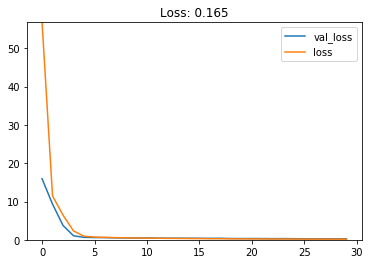

In [16]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(x_train.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

deep_history = deep_model.fit(x_train, y_train, epochs=30, validation_split=0.2)
plot_loss(deep_history)

In [17]:
# Save model
deep_model.save('predict_salary.h5')

In [18]:
# Load model
deep_model = load_model('predict_salary.h5')

In [19]:
# Predict
#y_predict = linr_model.predict(x_test)
y_predict = []
y_predict = deep_model.predict(x_test)
print(type(y_predict))

<class 'numpy.ndarray'>


In [20]:
# Reshape y_test về cùng hình dạng với y_predict
y_test = np.array([y_test]).T

In [21]:
print(y_predict.shape)
print(y_test.shape)

(1000, 1)
(1000, 1)


In [22]:
for i in range(10):
    print("predict = ", y_predict[i])
    print("label = ", y_test[i])
    print('\n')


predict =  [15.870543]
label =  [16.]


predict =  [5.009474]
label =  [5.]


predict =  [6.556749]
label =  [7.1]


predict =  [5.0223]
label =  [5.]


predict =  [10.403472]
label =  [11.1]


predict =  [13.946629]
label =  [14.]


predict =  [8.236203]
label =  [8.5]


predict =  [8.85568]
label =  [9.]


predict =  [5.024488]
label =  [5.]


predict =  [5.5243406]
label =  [5.]




In [23]:
# Đánh giá độ chính xác với ngưỡng chênh < 1tr
accuracy = (abs(y_test - y_predict) <= 1.0).mean() * 100
print("Độ chính xác dự đoán lương = ", accuracy,"%")

Độ chính xác dự đoán lương =  99.4 %
